Epoch [1/5], Loss: 2.9917
Epoch [2/5], Loss: 2.5077
Epoch [3/5], Loss: 2.4634
Epoch [4/5], Loss: 2.4450
Epoch [5/5], Loss: 2.4337
敵対的トレーニング完了


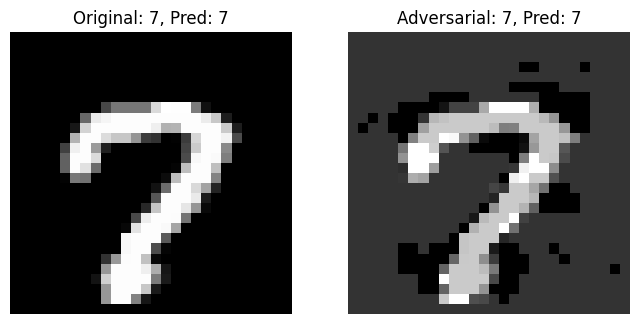

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# 簡単なモデルの定義
class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.fc = nn.Linear(28 * 28, 10)
    
    def forward(self, x):
        x = x.view(-1, 28 * 28)
        return self.fc(x)

# 敵対的サンプルを生成する関数 (FGSM: Fast Gradient Sign Method)
def generate_adversarial_sample(model, x, y, epsilon=0.2):
    x.requires_grad = True
    outputs = model(x)
    loss = nn.CrossEntropyLoss()(outputs, y)
    model.zero_grad()
    loss.backward()
    # 勾配の符号に基づいて敵対的サンプルを生成
    adv_x = x + epsilon * x.grad.sign()
    adv_x = torch.clamp(adv_x, 0, 1)  # ピクセル値を[0,1]にクリップ
    return adv_x

# ハイパーパラメータ
batch_size = 64
learning_rate = 0.01
num_epochs = 5
epsilon = 0.2

# データセットの準備
transform = transforms.ToTensor()
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

# モデル、損失関数、オプティマイザ
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleModel().to(device)
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# 敵対的トレーニングの実行
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch_idx, (x, y) in enumerate(train_loader):
        x, y = x.to(device), y.to(device)
        
        # 元のデータでのトレーニング
        outputs = model(x)
        loss = nn.CrossEntropyLoss()(outputs, y)
        
        # 敵対的サンプルを生成
        adv_x = generate_adversarial_sample(model, x, y, epsilon)
        
        # 敵対的サンプルでのトレーニング
        adv_outputs = model(adv_x)
        adv_loss = nn.CrossEntropyLoss()(adv_outputs, y)
        
        # 元データと敵対的サンプルの損失を結合
        total_batch_loss = loss + adv_loss
        
        # 勾配の計算とモデルの更新
        optimizer.zero_grad()
        total_batch_loss.backward()
        optimizer.step()
        
        total_loss += total_batch_loss.item()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss / len(train_loader):.4f}")

print("敵対的トレーニング完了")

# テストデータでの検証と可視化
model.eval()
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=1, shuffle=True)

# テストデータからサンプルを1つ取得して表示
x, y = next(iter(test_loader))
x, y = x.to(device), y.to(device)

# 元の画像
output = model(x)
_, pred = torch.max(output, 1)

# 敵対的サンプルの生成
adv_x = generate_adversarial_sample(model, x, y)

# 敵対的画像での予測
adv_output = model(adv_x)
_, adv_pred = torch.max(adv_output, 1)

# 可視化
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title(f"Original: {y.item()}, Pred: {pred.item()}")
plt.imshow(x.squeeze(0).detach().cpu().numpy().transpose(1, 2, 0), cmap='gray')  # 修正済み
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title(f"Adversarial: {y.item()}, Pred: {adv_pred.item()}")
plt.imshow(adv_x.squeeze(0).detach().cpu().numpy().transpose(1, 2, 0), cmap='gray')  # 修正済み
plt.axis('off')

plt.show()
